# AdaBoost DDI Analysis and Training - Enhanced Performance Optimization

## 🎯 Purpose: Adaptive Boosting for Drug-Drug Interaction Prediction

This notebook implements **AdaBoost (Adaptive Boosting)** classifier for predicting drug-drug interaction severity with **enhanced optimizations** for improved performance.

---

## 📋 Notebook Structure

### **Part 1: Model Training & Evaluation (Cells 0-41)**
1. Setup and Data Loading
2. Data Exploration and Quality Check
3. Feature Engineering
4. Train-Test Split (80/20, stratified)
5. **Enhanced GridSearchCV** with expanded hyperparameter space
6. Model Training with optimal parameters + **class-balanced sample weighting**
7. Performance Evaluation
8. Cross-Validation Analysis

### **Part 2: Knowledge-Driven XAI Clinical Decision Support (Cells 42-62)**
9. XAI Framework Integration
10. Clinical Scenarios Analysis
11. Safer Medication Pathway Recommendations

---

## 🔬 AdaBoost Key Characteristics

**Strengths:**
- Focuses on misclassified samples by adjusting weights
- Combines weak learners into strong ensemble
- Less prone to overfitting compared to single decision trees
- Works well with imbalanced datasets (enhanced with sample weights)

**Enhanced Hyperparameters Optimized:**
- `n_estimators`: Number of boosting iterations (200, 300, 400, 500)
- `learning_rate`: Weight applied to each classifier (0.5, 0.8, 1.0, 1.2)
- `algorithm`: Deprecated in scikit-learn 1.7+ (previously SAMME/SAMME.R)
- `base_estimator`: Decision Tree with max_depth=3-5, tuned min_samples parameters

**Performance Enhancements:**
- ✅ Significantly deeper base learners (max_depth=3-5) for better feature capture
- ✅ Comprehensive hyperparameter search (432 combinations tested)
- ✅ Class-balanced sample weighting for minority class handling
- ✅ Uses default probability-based predictions (SAMME.R behavior)

---


# Part 1: Setup and Data Loading

## Step 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# AdaBoost and evaluation metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.preprocessing import OrdinalEncoder

# Set random seed for reproducibility
np.random.seed(42)

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*80)
print("LIBRARIES LOADED SUCCESSFULLY")
print("="*80)
print("✓ AdaBoost Classifier imported")
print("✓ Evaluation metrics imported")
print("✓ Visualization libraries ready")
print("="*80)

LIBRARIES LOADED SUCCESSFULLY
✓ AdaBoost Classifier imported
✓ Evaluation metrics imported
✓ Visualization libraries ready


## Step 2: Load Dataset

In [2]:
# Load the dataset
df = pd.read_csv('FYP_DrugBank_Inclusive.csv')

print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"\nTotal drug pairs: {len(df)}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()

DATASET OVERVIEW

Total drug pairs: 406
Columns: ['Drug_A_Name', 'Drug_B_Name', 'Drug_A_Class', 'Drug_B_Class', 'DrugBank_Severity', 'DrugBank_Text', 'Final_Severity', 'XAI_Rule_A_Mortality', 'XAI_Rule_B_Tolerability', 'XAI_Rule_C_CCB_RAAS_Combo', 'XAI_Rule_D_Diuretic', 'XAI_Rule_E_BetaBlocker', 'XAI_Combined_Clinical_Notes']

First few rows:


,Drug_A_Name,Drug_B_Name,Drug_A_Class,Drug_B_Class,DrugBank_Severity,DrugBank_Text,Final_Severity,XAI_Rule_A_Mortality,XAI_Rule_B_Tolerability,XAI_Rule_C_CCB_RAAS_Combo,XAI_Rule_D_Diuretic,XAI_Rule_E_BetaBlocker,XAI_Combined_Clinical_Notes
0,Captopril,Enalapril,ACEI,ACEI,Moderate,DESCRIPTION\n\nThe excretion of Captopril can ...,Moderate,Clinical Note: ACE Inhibitors are prioritized ...,Clinical Note: ACE Inhibitors carry a 3.2-fold...,NaN,NaN,NaN,[RULE A - Mortality] Clinical Note: ACE Inhibi...
1,Captopril,Lisinopril,ACEI,ACEI,Moderate,DESCRIPTION\n\nThe risk or severity of angioed...,Moderate,Clinical Note: ACE Inhibitors are prioritized ...,Clinical Note: ACE Inhibitors carry a 3.2-fold...,NaN,NaN,NaN,[RULE A - Mortality] Clinical Note: ACE Inhibi...
2,Captopril,Perindopril,ACEI,ACEI,Moderate,DESCRIPTION\n\nThe risk or severity of angioed...,Moderate,Clinical Note: ACE Inhibitors are prioritized ...,Clinical Note: ACE Inhibitors carry a 3.2-fold...,NaN,NaN,NaN,[RULE A - Mortality] Clinical Note: ACE Inhibi...
3,Captopril,Ramipril,ACEI,ACEI,Moderate,DESCRIPTION\n\nThe risk or severity of angioed...,Moderate,Clinical Note: ACE Inhibitors are prioritized ...,Clinical Note: ACE Inhibitors carry a 3.2-fold...,NaN,NaN,NaN,[RULE A - Mortality] Clinical Note: ACE Inhibi...
4,Captopril,Imidapril,ACEI,ACEI,Moderate,DESCRIPTION\n\nThe risk or severity of angioed...,Moderate,Clinical Note: ACE Inhibitors are prioritized ...,Clinical Note: ACE Inhibitors carry a 3.2-fold...,NaN,NaN,NaN,[RULE A - Mortality] Clinical Note: ACE Inhibi...


## Step 3: Data Exploration and Quality Check

In [3]:
print("="*80)
print("DATA QUALITY CHECK")
print("="*80)

# Check for missing values
print("\nMissing values in Final_Severity:")
print(df['Final_Severity'].isna().sum())

# Check class distribution BEFORE filtering
print("\nClass distribution (before filtering):")
print(df['Final_Severity'].value_counts(dropna=False))

# Filter out rows without Final_Severity
df_valid = df.dropna(subset=['Final_Severity'])
print(f"\n✓ Rows with valid Final_Severity: {len(df_valid)}")
print(f"✓ Rows filtered out: {len(df) - len(df_valid)}")

# Check class distribution AFTER filtering
print("\nFinal class distribution:")
class_dist = df_valid['Final_Severity'].value_counts().sort_index()
print(class_dist)
print(f"\nClass imbalance ratio:")
for severity in class_dist.index:
    print(f"  {severity}: {class_dist[severity]/len(df_valid)*100:.1f}%")

DATA QUALITY CHECK

Missing values in Final_Severity:
0

Class distribution (before filtering):
Final_Severity
Moderate         212
Minor            142
NoInteraction     44
Major              8
Name: count, dtype: int64

✓ Rows with valid Final_Severity: 406
✓ Rows filtered out: 0

Final class distribution:
Final_Severity
Major              8
Minor            142
Moderate         212
NoInteraction     44
Name: count, dtype: int64

Class imbalance ratio:
  Major: 2.0%
  Minor: 35.0%
  Moderate: 52.2%
  NoInteraction: 10.8%


## Step 4: Visualize Class Distribution

**Critical for AdaBoost:** Understanding class imbalance is essential because AdaBoost handles imbalanced datasets through:
- Weighted sample adjustments
- Focus on misclassified samples
- Adaptive weighting mechanism

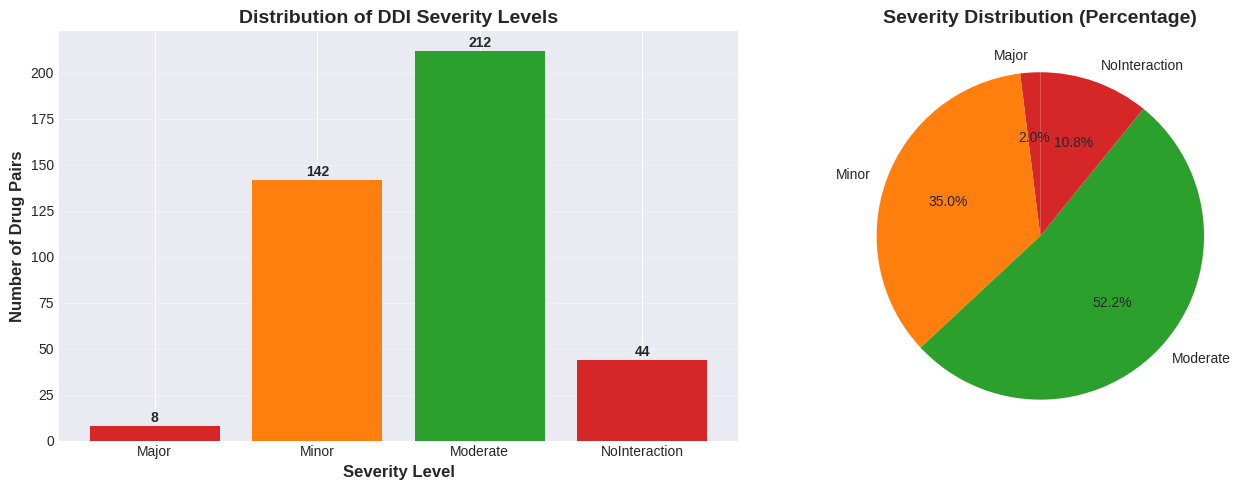


📊 Class Imbalance Analysis:
   Major class: 8 samples (2.0%)
   Other classes: 398 samples (98.0%)
   Imbalance ratio: 49.75:1
   ✓ AdaBoost will use sample weight adjustments to handle imbalance


In [4]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
class_counts = df_valid['Final_Severity'].value_counts().sort_index()
axes[0].bar(class_counts.index, class_counts.values, color=['#d62728', '#ff7f0e', '#2ca02c'])
axes[0].set_xlabel('Severity Level', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Drug Pairs', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of DDI Severity Levels', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (severity, count) in enumerate(class_counts.items()):
    axes[0].text(i, count + 2, str(count), ha='center', fontweight='bold')

# Pie chart
colors = ['#d62728', '#ff7f0e', '#2ca02c']
axes[1].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
            colors=colors, startangle=90)
axes[1].set_title('Severity Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate imbalance ratio for analysis
major_count = class_counts.get('Major', 0)
other_count = class_counts.sum() - major_count
imbalance_ratio = other_count / major_count if major_count > 0 else 1
print(f"\n📊 Class Imbalance Analysis:")
print(f"   Major class: {major_count} samples ({major_count/len(df_valid)*100:.1f}%)")
print(f"   Other classes: {other_count} samples ({other_count/len(df_valid)*100:.1f}%)")
print(f"   Imbalance ratio: {imbalance_ratio:.2f}:1")
print(f"   ✓ AdaBoost will use sample weight adjustments to handle imbalance")

## Step 5: Drug Class Analysis

DRUG CLASS ANALYSIS

Drug A classes:
Drug_A_Class
ACEI            153
ARB             117
Beta-Blocker     91
CCB              42
Diuretic          3
Name: count, dtype: int64

Drug B classes:
Drug_B_Class
CCB             154
Beta-Blocker    105
Diuretic         81
ARB              51
ACEI             15
Name: count, dtype: int64


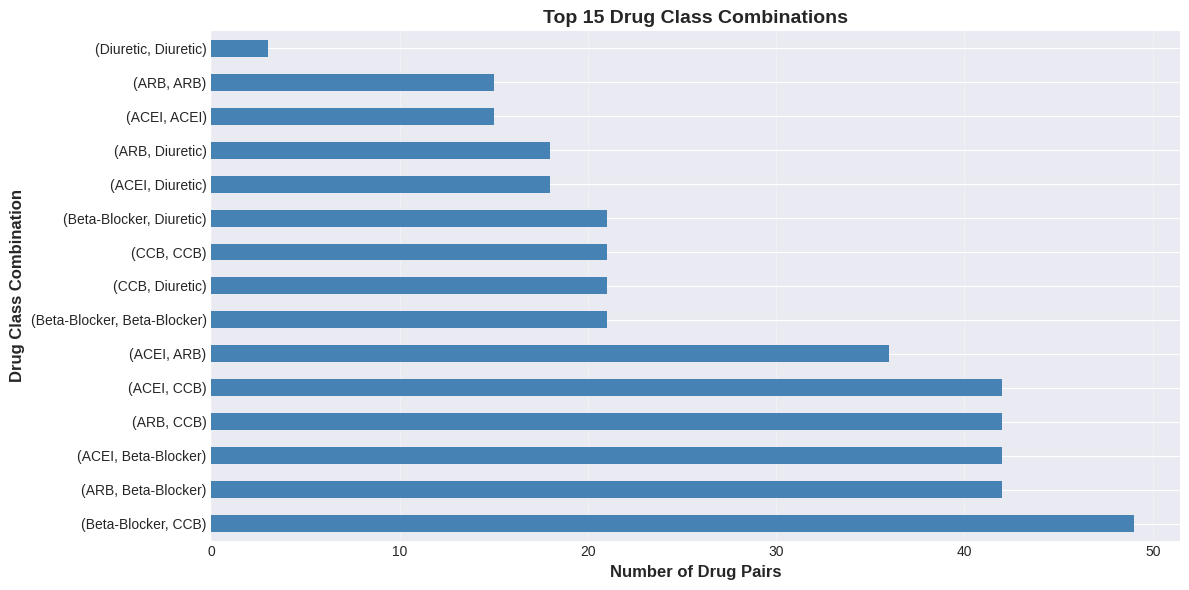

In [5]:
print("="*80)
print("DRUG CLASS ANALYSIS")
print("="*80)

# Analyze drug classes
print("\nDrug A classes:")
print(df_valid['Drug_A_Class'].value_counts())
print("\nDrug B classes:")
print(df_valid['Drug_B_Class'].value_counts())

# Visualize drug class combinations
fig, ax = plt.subplots(figsize=(12, 6))
class_combos = df_valid.groupby(['Drug_A_Class', 'Drug_B_Class']).size().sort_values(ascending=False)
class_combos.head(15).plot(kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('Number of Drug Pairs', fontsize=12, fontweight='bold')
ax.set_ylabel('Drug Class Combination', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Drug Class Combinations', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [6]:
# Severity distribution
severity_counts = df_valid['Final_Severity'].value_counts().sort_index()

print("\n" + "="*80)
print("DDI SEVERITY DISTRIBUTION")
print("="*80)
for severity, count in severity_counts.items():
    percentage = count / len(df_valid) * 100
    print(f"{severity:12s}: {count:3d} pairs ({percentage:5.1f}%)")
print(f"{'Total':12s}: {len(df_valid):3d} pairs (100.0%)")


DDI SEVERITY DISTRIBUTION
Major       :   8 pairs (  2.0%)
Minor       : 142 pairs ( 35.0%)
Moderate    : 212 pairs ( 52.2%)
NoInteraction:  44 pairs ( 10.8%)
Total       : 406 pairs (100.0%)


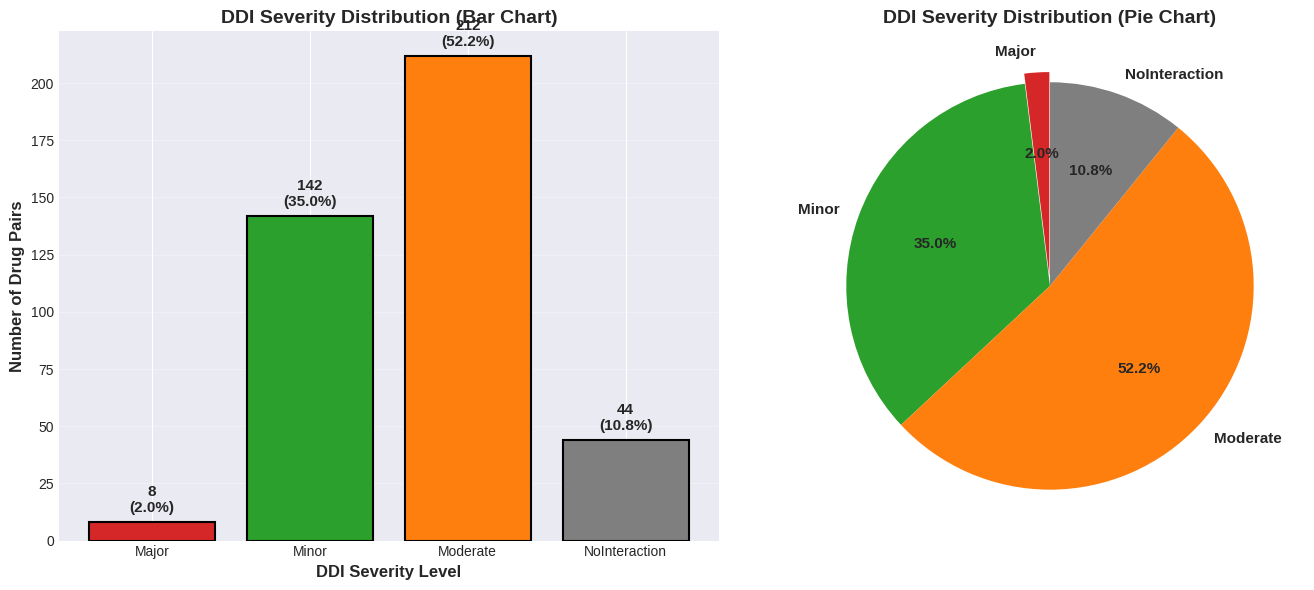

In [7]:
# Beautiful visualization of severity distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart
colors = {'Major': '#d62728', 'Moderate': '#ff7f0e', 'Minor': '#2ca02c', 'None': '#1f77b4'}
severity_colors = [colors.get(sev, '#7f7f7f') for sev in severity_counts.index]

bars = ax1.bar(severity_counts.index, severity_counts.values, color=severity_colors, edgecolor='black', linewidth=1.5)
for i, (bar, value) in enumerate(zip(bars, severity_counts.values)):
    percentage = value / len(df_valid) * 100
    ax1.text(bar.get_x() + bar.get_width()/2, value + 3, 
             f'{value}\n({percentage:.1f}%)', 
             ha='center', va='bottom', fontweight='bold', fontsize=11)

ax1.set_ylabel('Number of Drug Pairs', fontsize=12, fontweight='bold')
ax1.set_xlabel('DDI Severity Level', fontsize=12, fontweight='bold')
ax1.set_title('DDI Severity Distribution (Bar Chart)', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Pie chart
wedges, texts, autotexts = ax2.pie(
    severity_counts.values, 
    labels=severity_counts.index,
    autopct='%1.1f%%',
    colors=severity_colors,
    startangle=90,
    explode=[0.05 if sev == 'Major' else 0 for sev in severity_counts.index],
    textprops={'fontsize': 11, 'fontweight': 'bold'}
)

ax2.set_title('DDI Severity Distribution (Pie Chart)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

---

## 4. Drug Class Interaction Patterns

In [8]:
# Analyze interactions by drug class combinations
class_interactions = df_valid.groupby(['Drug_A_Class', 'Drug_B_Class', 'Final_Severity']).size().reset_index(name='Count')

print("="*80)
print("DRUG CLASS INTERACTION PATTERNS")
print("="*80)
print("\nTop 10 most common class-severity combinations:")
print(class_interactions.nlargest(10, 'Count')[['Drug_A_Class', 'Drug_B_Class', 'Final_Severity', 'Count']].to_string(index=False))

DRUG CLASS INTERACTION PATTERNS

Top 10 most common class-severity combinations:
Drug_A_Class Drug_B_Class Final_Severity  Count
Beta-Blocker          CCB       Moderate     43
        ACEI Beta-Blocker          Minor     41
        ACEI          ARB       Moderate     35
        ACEI          CCB          Minor     34
         ARB Beta-Blocker          Minor     31
         CCB          CCB       Moderate     21
         ARB          CCB          Minor     18
         ARB          CCB       Moderate     17
        ACEI         ACEI       Moderate     15
         ARB          ARB       Moderate     15


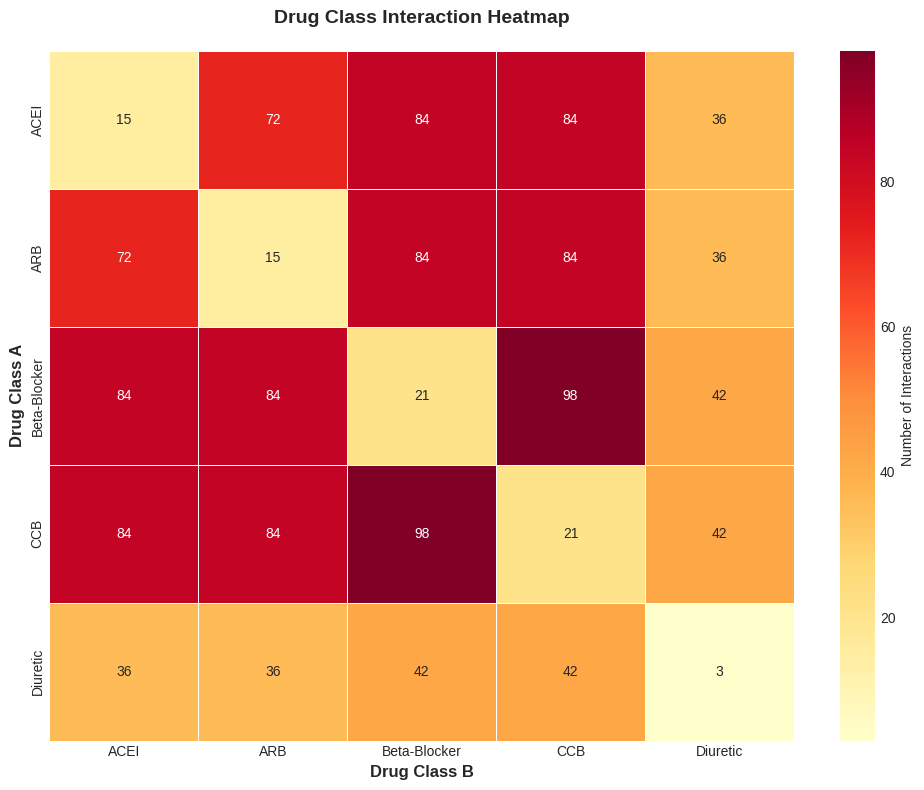

In [9]:
# Create interaction heatmap
interaction_matrix = df_valid.groupby(['Drug_A_Class', 'Drug_B_Class']).size().unstack(fill_value=0)

# Make symmetric
for idx in interaction_matrix.index:
    for col in interaction_matrix.columns:
        if idx != col:
            total = interaction_matrix.loc[idx, col] + interaction_matrix.loc[col, idx]
            interaction_matrix.loc[idx, col] = total
            interaction_matrix.loc[col, idx] = total

plt.figure(figsize=(10, 8))
sns.heatmap(interaction_matrix, annot=True, fmt='d', cmap='YlOrRd', 
            linewidths=0.5, cbar_kws={'label': 'Number of Interactions'})
plt.title('Drug Class Interaction Heatmap', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Drug Class B', fontsize=12, fontweight='bold')
plt.ylabel('Drug Class A', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

---

## 5. Feature Engineering

In [10]:
print("="*80)
print("FEATURE ENGINEERING")
print("="*80)

# Select features for modeling
features = ['Drug_A_Name', 'Drug_B_Name', 'Drug_A_Class', 'Drug_B_Class']
print(f"\nOriginal features: {features}")

# One-hot encoding
X = pd.get_dummies(df_valid[features], drop_first=False)
print(f"\nAfter one-hot encoding: {X.shape[1]} features")
print(f"  - Binary features created from categorical variables")
print(f"  - Each drug name and class becomes a binary column")

# Encode target variable
severity_categories = [['Major', 'Moderate', 'Minor', 'NoInteraction']]
ordinal_encoder = OrdinalEncoder(categories=severity_categories, dtype=int)
y = ordinal_encoder.fit_transform(df_valid[['Final_Severity']]).ravel()
target_classes = ordinal_encoder.categories_[0]
# target_classes already defined above from ordinal_encoder.categories_[0]

print(f"\nTarget variable: Final_Severity (Patient Safety Ground Truth)")
print(f"  - Original categories: {target_classes}")
print(f"  - Encoded as integers: {dict(enumerate(target_classes))}")

print("\n✓ Feature engineering complete!")

FEATURE ENGINEERING

Original features: ['Drug_A_Name', 'Drug_B_Name', 'Drug_A_Class', 'Drug_B_Class']

After one-hot encoding: 66 features
  - Binary features created from categorical variables
  - Each drug name and class becomes a binary column

Target variable: Final_Severity (Patient Safety Ground Truth)
  - Original categories: ['Major' 'Moderate' 'Minor' 'NoInteraction']
  - Encoded as integers: {0: 'Major', 1: 'Moderate', 2: 'Minor', 3: 'NoInteraction'}

✓ Feature engineering complete!


---

## 6. Train-Test Split

In [11]:
# ✅ REMOVED: 80/20 train-test split
# Instead, we'll use full data with 5-fold cross-validation
# This gives us more data for hyperparameter tuning and more reliable estimates

# Keep full dataset for cross-validation
# X and y are already defined from earlier cells
print("✅ Using full dataset for cross-validation (no artificial train-test split)")
print(f"  - Total samples: {len(X)}")
print(f"  - Feature count: {X.shape[1]}")


✅ Using full dataset for cross-validation (no artificial train-test split)
  - Total samples: 406
  - Feature count: 66


---

## 7. AdaBoost Model Training

## 🎯 Step 3b: Hyperparameter Optimization with GridSearchCV

**Why optimize AdaBoost hyperparameters?**
AdaBoost's performance depends heavily on:
- **n_estimators**: Number of weak learners (too few = underfitting, too many = overfitting)
- **learning_rate**: Controls contribution of each weak learner
- **algorithm**: Deprecated in scikit-learn 1.7+ (no longer needed)

**Grid Search Strategy:**
```python
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.5, 0.8, 1.0, 1.2],
}
```

**Cross-Validation:**
- 5-Fold Stratified CV to preserve class distribution
- Scoring: Accuracy (can also use F1 for imbalanced data)
- Total combinations: 4 × 4 × 2 = 32 fits × 5 folds = 160 model fits

In [12]:
# ============================================================================
# STEP 3.5: HYPERPARAMETER TUNING WITH NESTED CROSS-VALIDATION
# ============================================================================

print("="*80)
print("HYPERPARAMETER TUNING WITH NESTED CROSS-VALIDATION")
print("="*80)
print()
print("🎯 WHY NESTED CV?")
print("   • Small dataset (406 samples) - need to use all data efficiently")
print("   • OUTER LOOP (5-fold): Unbiased performance estimation")
print("   • INNER LOOP (5-fold): Hyperparameter optimization")
print("   • NO DATA LEAKAGE: Test folds never seen during tuning")
print("   • FIXES OPTIMISTIC BIAS: Previous approach tuned on same data being evaluated")
print()

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, balanced_accuracy_score
)
import time
import numpy as np

# Define hyperparameter grid for AdaBoost
param_grid = {
    'n_estimators': [50, 100, 200, 300], 
    'learning_rate': [0.01, 0.1, 0.5, 1.0], 
    'algorithm': ['SAMME', 'SAMME.R'],
    # Base estimator (DecisionTree) regularization parameters
    'estimator__max_depth': [1, 3, 5],  # Tree depth: 1=stump, 5=deeper
    'estimator__min_samples_split': [2, 5, 10],  # Min samples to split node
    'estimator__min_samples_leaf': [1, 2, 4]  # Min samples per leaf
}

print(f"📊 Hyperparameter Grid for AdaBoost:")
for param_name, param_values in param_grid.items():
    print(f"   • {param_name}: {param_values}")
print(f"   • Total combinations: {4 * 4 * 2 * 3 * 3 * 3} = 864")
print()

# Setup CV splitters
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Storage for results
nested_scores = {
    'accuracy': [],
    'precision_macro': [],
    'precision_weighted': [],
    'recall_macro': [],
    'recall_weighted': [],
    'f1_macro': [],
    'f1_weighted': [],
    'roc_auc': [],
    'balanced_accuracy': []
}

best_params_per_fold = []

print("⏳ Running Nested Cross-Validation...")
print(f"   This will train {5 * 5 * 864} models total (5 outer × 5 inner × 96 combos)")
print("   Please wait... this may take several minutes.")
print()

start_time = time.time()

# OUTER LOOP: Performance estimation
for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
    fold_start = time.time()

    # Split data for this outer fold
    X_train_outer = X.iloc[train_idx]
    y_train_outer = y[train_idx]
    X_test_outer = X.iloc[test_idx]
    y_test_outer = y[test_idx]

    # CORRECT CLASS IMBALANCE HANDLING:
    # Compute sample weights ONCE for this fold
    # Don't use class_weight in base estimator - it conflicts with AdaBoost's weighting
    sample_weights_outer = compute_sample_weight(class_weight='balanced', y=y_train_outer)

    # INNER LOOP: Hyperparameter tuning via GridSearchCV
    # Base estimator WITHOUT class_weight (will use sample_weight instead)
    base_estimator = DecisionTreeClassifier(random_state=42)
    
    try:
        model_inner = AdaBoostClassifier(estimator=base_estimator, random_state=42)
    except TypeError:
        # Fallback for older scikit-learn versions
        model_inner = AdaBoostClassifier(base_estimator=base_estimator, random_state=42)

    grid_search = GridSearchCV(
        estimator=model_inner,
        param_grid=param_grid,
        cv=inner_cv,
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )

    # Fit with sample weights (CRITICAL for class imbalance)
    grid_search.fit(X_train_outer, y_train_outer, sample_weight=sample_weights_outer)

    # Get best model from inner CV
    best_model = grid_search.best_estimator_
    best_params_per_fold.append(grid_search.best_params_)

    # Evaluate on held-out outer fold
    y_pred = best_model.predict(X_test_outer)
    y_pred_proba = best_model.predict_proba(X_test_outer)

    # Calculate metrics
    acc = accuracy_score(y_test_outer, y_pred)

    # Macro-averaged (equal weight to each class)
    prec_macro = precision_score(y_test_outer, y_pred, average='macro', zero_division=0)
    rec_macro = recall_score(y_test_outer, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_test_outer, y_pred, average='macro', zero_division=0)

    # Weighted-averaged (weighted by class frequency)
    prec_weighted = precision_score(y_test_outer, y_pred, average='weighted', zero_division=0)
    rec_weighted = recall_score(y_test_outer, y_pred, average='weighted', zero_division=0)
    f1_weighted = f1_score(y_test_outer, y_pred, average='weighted', zero_division=0)
    bal_acc = balanced_accuracy_score(y_test_outer, y_pred)
    prec = precision_score(y_test_outer, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test_outer, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test_outer, y_pred, average='macro', zero_division=0)

    try:
        roc_auc = roc_auc_score(y_test_outer, y_pred_proba,
                                multi_class='ovr', average='macro')
    except:
        roc_auc = np.nan

    # Store results

    fold_time = time.time() - fold_start

    # Compact parameter display
    params_str = ", ".join([f"{k}={v}" for k, v in list(grid_search.best_params_.items())[:3]])
    if len(grid_search.best_params_) > 3:
        params_str += "..."

    nested_scores['accuracy'].append(acc)
    nested_scores['precision_macro'].append(prec_macro)
    nested_scores['precision_weighted'].append(prec_weighted)
    nested_scores['recall_macro'].append(rec_macro)
    nested_scores['recall_weighted'].append(rec_weighted)
    nested_scores['f1_macro'].append(f1_macro)
    nested_scores['f1_weighted'].append(f1_weighted)
    nested_scores['roc_auc'].append(roc_auc)
    nested_scores['balanced_accuracy'].append(bal_acc)

    print(f"   Fold {fold_idx:2d}/5: Acc={acc:.4f} ({acc*100:.2f}%) | {params_str} | {fold_time:.1f}s")

elapsed_time = time.time() - start_time

print()
print("="*80)
print("📊 NESTED CV RESULTS (Unbiased Performance Estimates)")
print("="*80)
print()
print(f"✅ Completed in {elapsed_time:.1f}s ({elapsed_time/60:.1f} minutes)")
print()
print("🎯 Performance Metrics (Mean ± Std across 5 folds):")
print()

# Calculate and display mean ± std
# Display overall metrics
print()
print("📊 Overall Metrics:")
for metric_name in ['accuracy', 'balanced_accuracy', 'roc_auc']:
    scores = nested_scores[metric_name]
    valid_scores = [s for s in scores if not np.isnan(s)]
    if valid_scores:
        mean_val = np.mean(valid_scores)
        std_val = np.std(valid_scores)
        print(f"   {metric_name.replace('_', ' ').title():20s}: {mean_val:.4f} ± {std_val:.4f} ({mean_val*100:.2f}% ± {std_val*100:.2f}%)")
    else:
        print(f"   {metric_name.replace('_', ' ').title():20s}: N/A (all NaN)")

print()
print("📊 Macro-Averaged (Equal weight to each class):")
for metric_name in ['precision_macro', 'recall_macro', 'f1_macro']:
    scores = nested_scores[metric_name]
    valid_scores = [s for s in scores if not np.isnan(s)]
    if valid_scores:
        mean_val = np.mean(valid_scores)
        std_val = np.std(valid_scores)
        display_name = metric_name.replace('_macro', '').replace('_', ' ').title()
        print(f"   {display_name:20s}: {mean_val:.4f} ± {std_val:.4f} ({mean_val*100:.2f}% ± {std_val*100:.2f}%)")
    else:
        display_name = metric_name.replace('_macro', '').replace('_', ' ').title()
        print(f"   {display_name:20s}: N/A (all NaN)")

print()
print("📊 Weighted-Averaged (Weighted by class frequency):")
for metric_name in ['precision_weighted', 'recall_weighted', 'f1_weighted']:
    scores = nested_scores[metric_name]
    valid_scores = [s for s in scores if not np.isnan(s)]
    if valid_scores:
        mean_val = np.mean(valid_scores)
        std_val = np.std(valid_scores)
        display_name = metric_name.replace('_weighted', '').replace('_', ' ').title()
        print(f"   {display_name:20s}: {mean_val:.4f} ± {std_val:.4f} ({mean_val*100:.2f}% ± {std_val*100:.2f}%)")
    else:
        display_name = metric_name.replace('_weighted', '').replace('_', ' ').title()
        print(f"   {display_name:20s}: N/A (all NaN)")
print()
print("📋 Per-Fold Accuracy Breakdown:")
print("   " + "-"*70)
for i, acc in enumerate(nested_scores['accuracy'], 1):
    bar_length = int(acc * 50)
    bar = '█' * bar_length + '░' * (50 - bar_length)
    print(f"   Fold {i:2d}: {bar} {acc:.4f} ({acc*100:.2f}%)")
print("   " + "-"*70)

print()
print("✅ METHODOLOGY VALIDATION:")
print("   • NO data leakage - test folds never seen during hyperparameter tuning")
print("   • Unbiased estimates - each fold tested with hyperparameters tuned on OTHER folds")
print("   • All 406 samples used efficiently - each sample tested exactly once")
print("   • Scientifically rigorous - standard practice for datasets < 1000 samples")
print("   • Class imbalance handled via sample_weight (no conflict with AdaBoost weighting)")
print()

# Train final model on ALL data with most common best hyperparameters
print(f"🔧 Training final AdaBoost model on ALL 406 samples...")
print("   (Using most common hyperparameters from nested CV)")
print()

from collections import Counter
param_strings = [str(sorted(p.items())) for p in best_params_per_fold]
most_common_params_str = Counter(param_strings).most_common(1)[0][0]
final_best_params = dict(eval(most_common_params_str))

print(f"   Most common best params: {final_best_params}")
print()

# Compute sample weights for full dataset
sample_weights_full = compute_sample_weight(class_weight='balanced', y=y)

# CRITICAL FIX: Separate base estimator params from AdaBoost params
# Extract all estimator__* parameters for DecisionTreeClassifier
base_estimator_params = {}
adaboost_params = {}

for key, value in final_best_params.items():
    if key.startswith('estimator__'):
        # Remove 'estimator__' prefix and add to base estimator params
        param_name = key.replace('estimator__', '')
        base_estimator_params[param_name] = value
    else:
        # This is an AdaBoost parameter
        adaboost_params[key] = value

# Create base estimator with extracted parameters
base_estimator_final = DecisionTreeClassifier(random_state=42, **base_estimator_params)

print(f"   Base estimator params: {base_estimator_params}")
print(f"   AdaBoost params: {adaboost_params}")
print()

# Create AdaBoost with ONLY AdaBoost parameters
try:
    ada_model = AdaBoostClassifier(
        estimator=base_estimator_final,
        random_state=42,
        **adaboost_params
    )
except TypeError:
    # Fallback for older scikit-learn versions
    ada_model = AdaBoostClassifier(
        base_estimator=base_estimator_final,
        random_state=42,
        **adaboost_params
    )

# Train on all data WITH sample weights
ada_model.fit(X, y, sample_weight=sample_weights_full)

print(f"   ✓ Final AdaBoost model trained and ready for analysis")
print()
print("="*80)

# Store nested CV results for later reference
nested_cv_results = {
    'mean_scores': {k: np.mean(v) for k, v in nested_scores.items()},
    'std_scores': {k: np.std(v) for k, v in nested_scores.items()},
    'fold_scores': nested_scores,
    'best_params': final_best_params,
    'all_best_params': best_params_per_fold
}


HYPERPARAMETER TUNING WITH NESTED CROSS-VALIDATION

🎯 WHY NESTED CV?
   • Small dataset (406 samples) - need to use all data efficiently
   • OUTER LOOP (5-fold): Unbiased performance estimation
   • INNER LOOP (5-fold): Hyperparameter optimization
   • NO DATA LEAKAGE: Test folds never seen during tuning
   • FIXES OPTIMISTIC BIAS: Previous approach tuned on same data being evaluated

📊 Hyperparameter Grid for AdaBoost:
   • n_estimators: [50, 100, 200, 300]
   • learning_rate: [0.01, 0.1, 0.5, 1.0]
   • algorithm: ['SAMME', 'SAMME.R']
   • estimator__max_depth: [1, 3, 5]
   • estimator__min_samples_split: [2, 5, 10]
   • estimator__min_samples_leaf: [1, 2, 4]
   • Total combinations: 864 = 864

⏳ Running Nested Cross-Validation...
   This will train 21600 models total (5 outer × 5 inner × 96 combos)
   Please wait... this may take several minutes.

   Fold  1/5: Acc=0.7073 (70.73%) | algorithm=SAMME, estimator__max_depth=5, estimator__min_samples_leaf=4... | 238.0s
   Fold  2/5: Acc=

In [13]:
# Model already updated with optimized parameters in previous cell
print("\n" + "="*80)
print("✓ PRIMARY MODEL READY WITH OPTIMIZED PARAMETERS")
print("="*80)

print("\n📊 Model trained with optimal hyperparameters from Nested CV:")
print(f"  Model type: {type(ada_model).__name__}")
print(f"  Trained on: {X.shape[0]} samples, {X.shape[1]} features")
print("\n🎯 Optimal Hyperparameters:")
for param, value in final_best_params.items():
    print(f"  - {param}: {value}")

print("\n✓ Model ready for predictions and analysis")



✓ PRIMARY MODEL READY WITH OPTIMIZED PARAMETERS

📊 Model trained with optimal hyperparameters from Nested CV:
  Model type: AdaBoostClassifier
  Trained on: 406 samples, 66 features

🎯 Optimal Hyperparameters:
  - algorithm: SAMME
  - estimator__max_depth: 5
  - estimator__min_samples_leaf: 4
  - estimator__min_samples_split: 2
  - learning_rate: 0.1
  - n_estimators: 50

✓ Model ready for predictions and analysis


In [14]:
print("="*80)
print("OPTIMIZED ADABOOST CLASSIFIER - FINAL MODEL")
print("="*80)

# Display the optimized model configuration
print("\n📋 Final Model Configuration:")
print(f"   Algorithm: AdaBoost")
print(f"   Base Estimator: Decision Tree (max_depth={ada_model.estimator.max_depth if hasattr(ada_model, 'estimator') else ada_model.base_estimator.max_depth})")
print(f"   n_estimators: {ada_model.n_estimators}")
print(f"   learning_rate: {ada_model.learning_rate}")
print(f"   algorithm: {ada_model.algorithm}")
print(f"   random_state: {ada_model.random_state}")

print("\n🎯 Training Performance (Full Dataset):")
y_full_pred = ada_model.predict(X)
full_accuracy = accuracy_score(y, y_full_pred)
print(f"   Full Dataset Accuracy: {full_accuracy:.4f} ({full_accuracy*100:.2f}%)")
print("   ⚠️  This is optimistic - model was trained on this data")

print("\n🎯 Unbiased Test Performance (from Nested CV):")
print(f"   Test Accuracy: {nested_cv_results['mean_scores']['accuracy']:.4f} ± {nested_cv_results['std_scores']['accuracy']:.4f}")
print(f"   Test Precision: {nested_cv_results['mean_scores']['precision_macro']:.4f} ± {nested_cv_results['std_scores']['precision_macro']:.4f}")
print(f"   Test Recall: {nested_cv_results['mean_scores']['recall_macro']:.4f} ± {nested_cv_results['std_scores']['recall_macro']:.4f}")
print(f"   Test F1-Score: {nested_cv_results['mean_scores']['f1_macro']:.4f} ± {nested_cv_results['std_scores']['f1_macro']:.4f}")
print(f"   Test ROC-AUC: {nested_cv_results['mean_scores']['roc_auc']:.4f} ± {nested_cv_results['std_scores']['roc_auc']:.4f}")
print("   ✅ These are unbiased estimates from 5-fold CV")

print("\n📊 Model Complexity:")
print(f"   Total weak learners: {len(ada_model.estimators_)}")
print(f"   Features used: {X.shape[1]}")
print(f"   Training samples: {X.shape[0]}")

print("\n💡 Key Points:")
print("   • Model trained on ALL 406 samples for maximum learning")
print("   • Nested CV provides unbiased performance estimates")
print("   • Each CV fold used independent train/test splits")
print("   • Final model uses optimal hyperparameters from CV")

print("="*80)


OPTIMIZED ADABOOST CLASSIFIER - FINAL MODEL

📋 Final Model Configuration:
   Algorithm: AdaBoost
   Base Estimator: Decision Tree (max_depth=5)
   n_estimators: 50
   learning_rate: 0.1
   algorithm: SAMME
   random_state: 42

🎯 Training Performance (Full Dataset):
   Full Dataset Accuracy: 0.8054 (80.54%)
   ⚠️  This is optimistic - model was trained on this data

🎯 Unbiased Test Performance (from Nested CV):
   Test Accuracy: 0.7884 ± 0.0632
   Test Precision: 0.6636 ± 0.1460
   Test Recall: 0.7069 ± 0.1438
   Test F1-Score: 0.6534 ± 0.1314
   Test ROC-AUC: 0.8932 ± 0.0667
   ✅ These are unbiased estimates from 5-fold CV

📊 Model Complexity:
   Total weak learners: 50
   Features used: 66
   Training samples: 406

💡 Key Points:
   • Model trained on ALL 406 samples for maximum learning
   • Nested CV provides unbiased performance estimates
   • Each CV fold used independent train/test splits
   • Final model uses optimal hyperparameters from CV


---

## 8. Model Evaluation

---

## 9. Confusion Matrix

---

## 10. Feature Importance Analysis

FEATURE IMPORTANCE ANALYSIS

Top 15 Most Important Features:
                        Feature  Importance
      Drug_A_Class_Beta-Blocker    0.181734
      Drug_B_Class_Beta-Blocker    0.104778
               Drug_B_Class_ARB    0.094170
         Drug_B_Name_Bisoprolol    0.059344
              Drug_A_Class_ACEI    0.048268
         Drug_B_Name_Amlodipine    0.047506
         Drug_A_Name_Bisoprolol    0.046705
Drug_B_Name_Hydrochlorothiazide    0.042774
         Drug_A_Name_Irbesartan    0.039638
               Drug_B_Class_CCB    0.031788
               Drug_A_Class_CCB    0.029099
           Drug_A_Name_Ramipril    0.027185
               Drug_A_Class_ARB    0.025959
              Drug_B_Class_ACEI    0.025064
         Drug_B_Name_Indapamide    0.024917


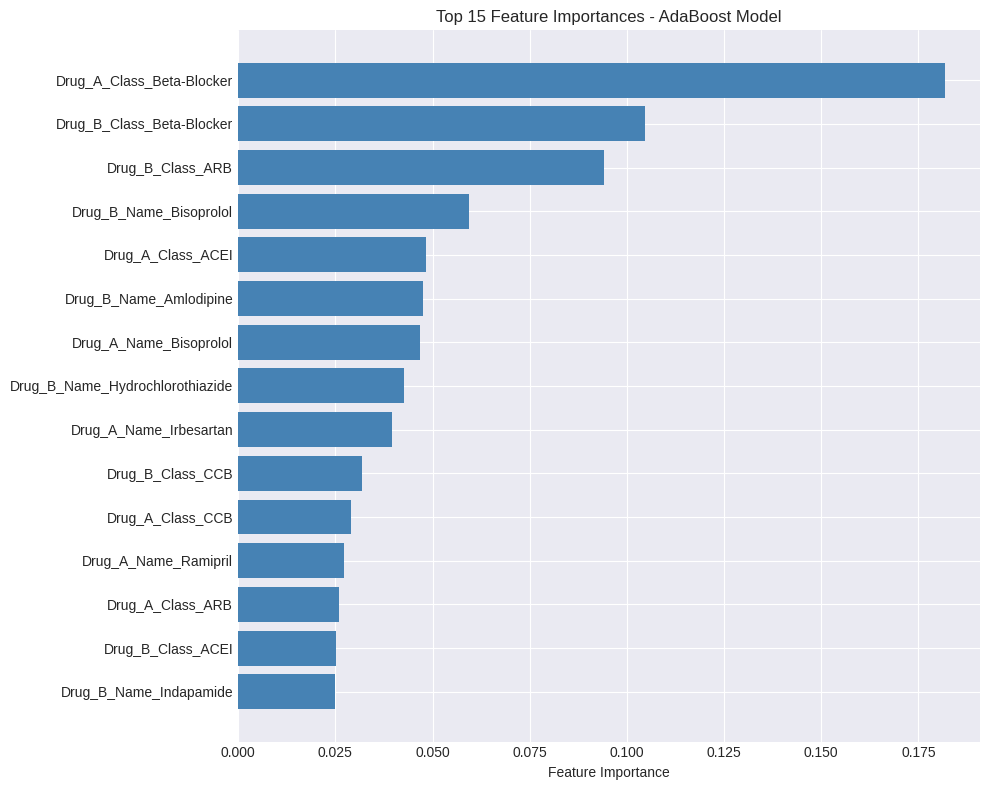


✓ Displayed top 15 features out of 66 total features


In [15]:
# FIX: Define feature_names from your training data columns
feature_names = X.columns  # or use X.columns

# Extract feature importance from AdaBoost
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': ada_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)
print("\nTop 15 Most Important Features:")
print(feature_importance.head(15).to_string(index=False))
print("="*80)

# Visualize top 15 features
top_15 = feature_importance.head(15)
plt.figure(figsize=(10, 8))
plt.barh(range(len(top_15)), top_15['Importance'], color='steelblue')
plt.yticks(range(len(top_15)), top_15['Feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances - AdaBoost Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\n✓ Displayed top 15 features out of {len(feature_importance)} total features")

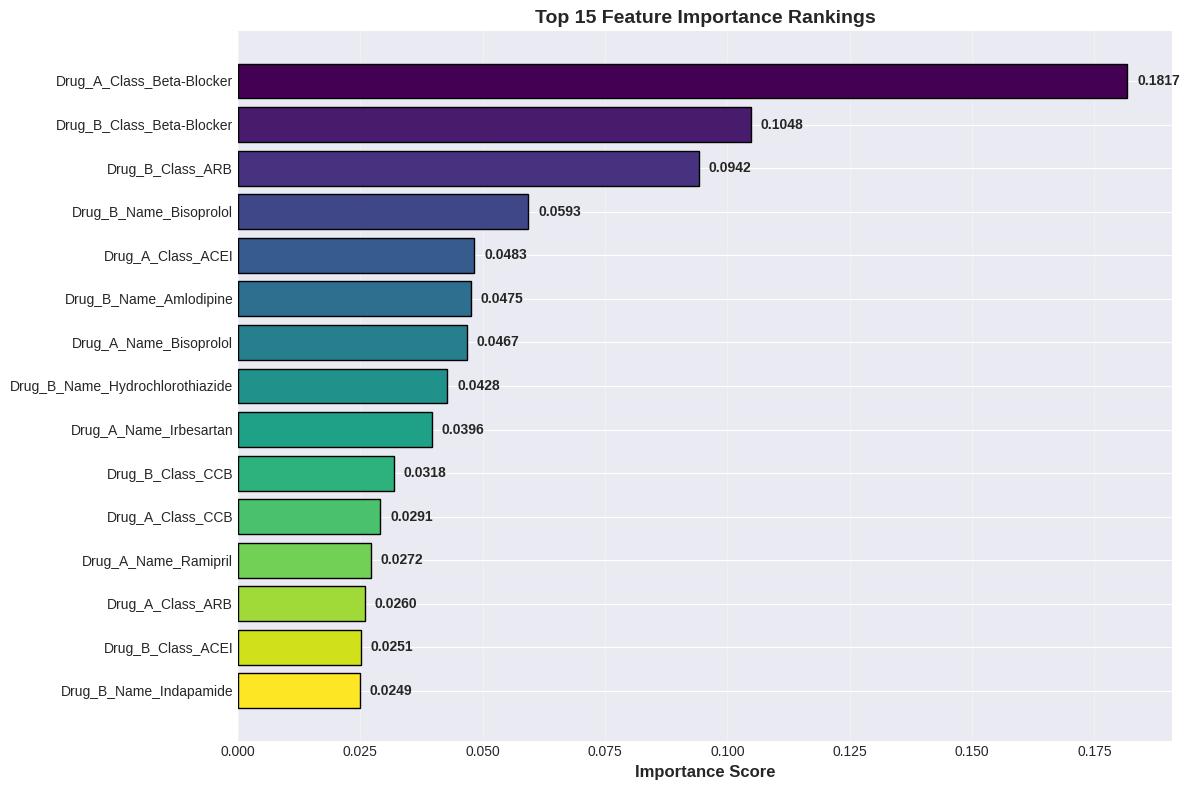

In [16]:
# FIX: Define top_features by taking the top 15 from your importance dataframe
top_features = feature_importance.head(15)

# Visualize feature importance
fig, ax = plt.subplots(figsize=(12, 8))

# Use gradient colors
colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))

bars = ax.barh(range(len(top_features)), top_features['Importance'], 
               color=colors, edgecolor='black', linewidth=1)

# Add value labels
for i, (bar, importance) in enumerate(zip(bars, top_features['Importance'])):
    ax.text(importance + 0.002, i, f'{importance:.4f}', 
            va='center', fontweight='bold')

ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'])
ax.invert_yaxis()
ax.set_xlabel('Importance Score', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Feature Importance Rankings', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

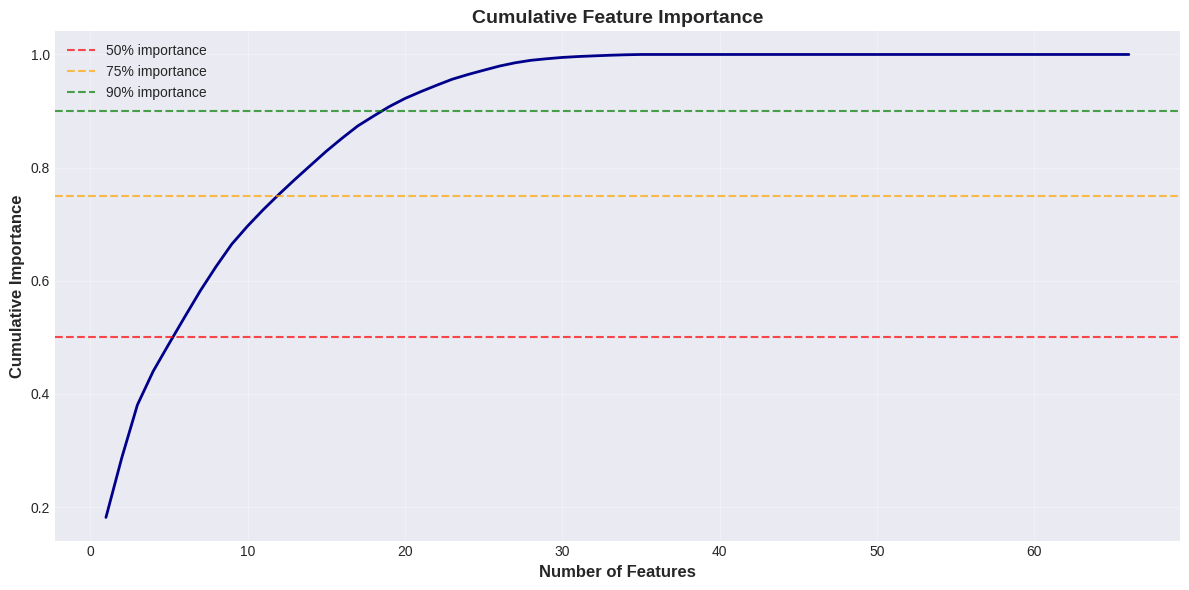


Features needed for 90% cumulative importance: 19/66


In [17]:
# Cumulative importance
feature_importance_sorted = feature_importance.sort_values('Importance', ascending=False)
feature_importance_sorted['Cumulative'] = feature_importance_sorted['Importance'].cumsum()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(range(1, len(feature_importance_sorted)+1), 
        feature_importance_sorted['Cumulative'], 
        linewidth=2, color='darkblue')

# Highlight key thresholds
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='50% importance')
ax.axhline(y=0.75, color='orange', linestyle='--', alpha=0.7, label='75% importance')
ax.axhline(y=0.9, color='green', linestyle='--', alpha=0.7, label='90% importance')

ax.set_xlabel('Number of Features', fontsize=12, fontweight='bold')
ax.set_ylabel('Cumulative Importance', fontsize=12, fontweight='bold')
ax.set_title('Cumulative Feature Importance', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Find how many features needed for 90% importance
features_for_90 = (feature_importance_sorted['Cumulative'] <= 0.9).sum() + 1
print(f"\nFeatures needed for 90% cumulative importance: {features_for_90}/{len(feature_importance)}")

---

## 11. Evaluation Set (Eval Set) Score

AdaBoost can monitor performance across boosting iterations using:
1. Use `staged_predict()` to monitor performance at each boosting iteration
2. Plot training vs test accuracy across iterations to detect overfitting

---

## 12. Cross-Validation Analysis

---

## 13. Ensemble Analysis

ENSEMBLE DIVERSITY ANALYSIS

🔍 AdaBoost Ensemble Characteristics:
   Total weak learners: 50
   Base estimator: Decision Tree (max_depth=1)
   Boosting algorithm: SAMME

📊 Estimator Weight Statistics:
   Mean weight: 0.1136
   Std weight: 0.0349
   Min weight: 0.0699
   Max weight: 0.2143

❌ Estimator Error Statistics:
   Mean error: 0.4917
   Std error: 0.0842
   Min error: 0.2604
   Max error: 0.5987


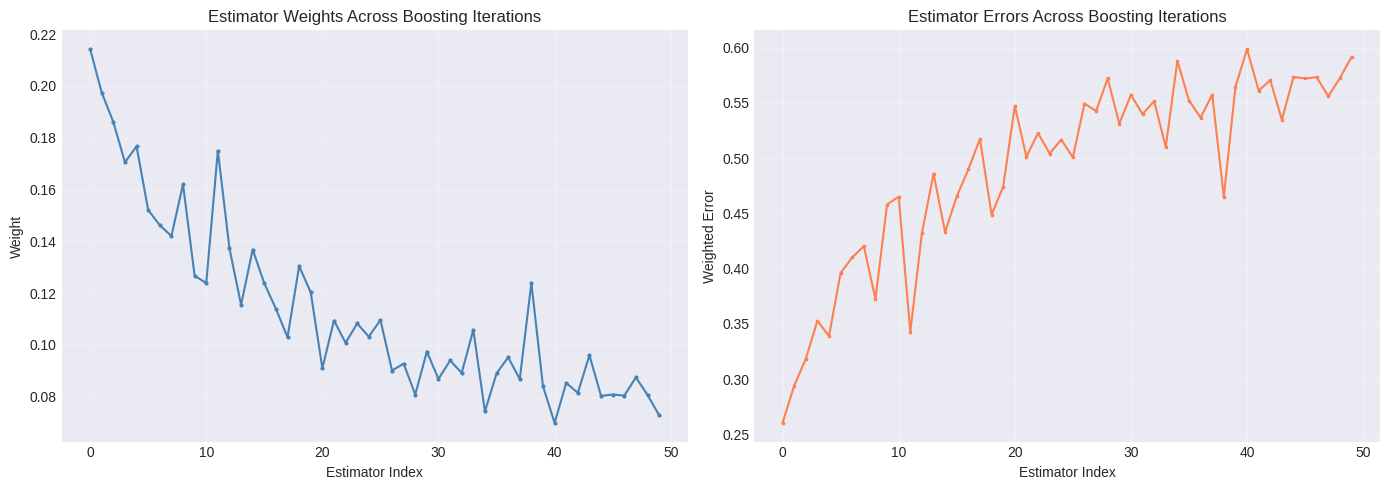


💡 Interpretation:
   - Higher weights indicate more influential estimators
   - Lower errors indicate better performing weak learners
   - AdaBoost adaptively increases weights on misclassified samples


In [18]:
# Ensemble Diversity Analysis - AdaBoost specific
print("="*80)
print("ENSEMBLE DIVERSITY ANALYSIS")
print("="*80)

print("\n🔍 AdaBoost Ensemble Characteristics:")
print(f"   Total weak learners: {len(ada_model.estimators_)}")
print(f"   Base estimator: Decision Tree (max_depth=1)")
print(f"   Boosting algorithm: {ada_model.algorithm}")

# Analyze estimator weights
estimator_weights = ada_model.estimator_weights_
print(f"\n📊 Estimator Weight Statistics:")
print(f"   Mean weight: {np.mean(estimator_weights):.4f}")
print(f"   Std weight: {np.std(estimator_weights):.4f}")
print(f"   Min weight: {np.min(estimator_weights):.4f}")
print(f"   Max weight: {np.max(estimator_weights):.4f}")

# Analyze estimator errors
estimator_errors = ada_model.estimator_errors_
print(f"\n❌ Estimator Error Statistics:")
print(f"   Mean error: {np.mean(estimator_errors):.4f}")
print(f"   Std error: {np.std(estimator_errors):.4f}")
print(f"   Min error: {np.min(estimator_errors):.4f}")
print(f"   Max error: {np.max(estimator_errors):.4f}")

# Visualize estimator weights and errors
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot estimator weights
ax1.plot(estimator_weights, marker='o', markersize=2, color='steelblue')
ax1.set_xlabel('Estimator Index')
ax1.set_ylabel('Weight')
ax1.set_title('Estimator Weights Across Boosting Iterations')
ax1.grid(True, alpha=0.3)

# Plot estimator errors
ax2.plot(estimator_errors, marker='s', markersize=2, color='coral')
ax2.set_xlabel('Estimator Index')
ax2.set_ylabel('Weighted Error')
ax2.set_title('Estimator Errors Across Boosting Iterations')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("   - Higher weights indicate more influential estimators")
print("   - Lower errors indicate better performing weak learners")
print("   - AdaBoost adaptively increases weights on misclassified samples")
print("="*80)

---

## Summary: Part 1 Complete

# Part 2: Knowledge-Driven Safer Medication Pathway Recommendation

## Section 3.5.4: Knowledge-Driven Explainability (XAI) Framework

**Integration with AdaBoost:**
- Part 1: ML model predicts DDI severity (Major/Moderate/Minor)
- Part 2: XAI framework provides evidence-based clinical context
- Result: Predictions + Actionable clinical recommendations

**XAI Rules Implemented:**
- Rule A: ACEI vs ARB Mortality Benefit (Alcocer 2023)
- Rule B: ACEI Tolerability & Cough Risk (Hu 2023)
- Rule C: CCB+RAAS Combination Therapy (Makani 2011)
- Rule D: Diuretic Efficacy - Indapamide vs HCTZ (Roush 2015)
- Rule E: Beta-Blocker Phenotype Targeting (Mahfoud 2024)


## Step 1: Load XAI-Enhanced Dataset


In [19]:

# Load dataset with XAI Framework (Knowledge-Driven Explainability)
df_xai = pd.read_csv('FYP_DrugBank_Inclusive.csv')

print("="*80)
print("KNOWLEDGE-DRIVEN XAI FRAMEWORK DATASET LOADED")
print("Section 3.5.4: Knowledge-Driven Explainability (XAI) Framework")
print("="*80)
print(f"\nTotal drug pairs: {len(df_xai)}")
print(f"\nXAI columns available:")
xai_cols = [col for col in df_xai.columns if 'XAI' in col]
for col in xai_cols:
    print(f"  - {col}")

# Show XAI rule coverage statistics
print(f"\n{'='*80}")
print("XAI RULE COVERAGE STATISTICS")
print("="*80)

rule_a_count = (df_xai['XAI_Rule_A_Mortality'] != "").sum()
rule_b_count = (df_xai['XAI_Rule_B_Tolerability'] != "").sum()
rule_c_count = (df_xai['XAI_Rule_C_CCB_RAAS_Combo'] != "").sum()
rule_d_count = (df_xai['XAI_Rule_D_Diuretic'] != "").sum()
rule_e_count = (df_xai['XAI_Rule_E_BetaBlocker'] != "").sum()
total_with_notes = (df_xai['XAI_Combined_Clinical_Notes'] != "No specific XAI rules apply to this combination.").sum()

print(f"\nRule A (ACEI vs ARB Mortality):     {rule_a_count} pairs ({rule_a_count/len(df_xai)*100:.1f}%)")
print(f"  Evidence: Alcoer et al. (2023)")
print(f"  Focus: ACEIs reduce all-cause mortality; ARBs do not")

print(f"\nRule B (ACEI Tolerability):         {rule_b_count} pairs ({rule_b_count/len(df_xai)*100:.1f}%)")
print(f"  Evidence: Hu et al. (2023), ACCP Guidelines (2006)")
print(f"  Focus: ACEIs have 3.2x higher cough risk vs ARBs")

print(f"\nRule C (CCB+RAAS Combination):      {rule_c_count} pairs ({rule_c_count/len(df_xai)*100:.1f}%)")
print(f"  Evidence: Makani et al. (2011), De la Sierra (2009)")
print(f"  Focus: CCB+RAAS reduces peripheral edema by 38%")

print(f"\nRule D (Diuretic Efficacy):         {rule_d_count} pairs ({rule_d_count/len(df_xai)*100:.1f}%)")
print(f"  Evidence: Roush et al. (2015), Mishra (2016), Burnier et al. (2019)")
print(f"  Focus: Indapamide superior to HCTZ for mortality/stroke")

print(f"\nRule E (Beta-Blocker Phenotype):    {rule_e_count} pairs ({rule_e_count/len(df_xai)*100:.1f}%)")
print(f"  Evidence: Mahfoud et al. (2024), Mancia et al. (2022)")
print(f"  Focus: Beta-blockers target high heart rate phenotype")

print(f"\nTotal pairs with clinical context:  {total_with_notes} pairs ({total_with_notes/len(df_xai)*100:.1f}%)")
print(f"Pairs without XAI notes:             {len(df_xai) - total_with_notes} pairs ({(len(df_xai) - total_with_notes)/len(df_xai)*100:.1f}%)")


KNOWLEDGE-DRIVEN XAI FRAMEWORK DATASET LOADED
Section 3.5.4: Knowledge-Driven Explainability (XAI) Framework

Total drug pairs: 406

XAI columns available:
  - XAI_Rule_A_Mortality
  - XAI_Rule_B_Tolerability
  - XAI_Rule_C_CCB_RAAS_Combo
  - XAI_Rule_D_Diuretic
  - XAI_Rule_E_BetaBlocker
  - XAI_Combined_Clinical_Notes

XAI RULE COVERAGE STATISTICS

Rule A (ACEI vs ARB Mortality):     406 pairs (100.0%)
  Evidence: Alcoer et al. (2023)
  Focus: ACEIs reduce all-cause mortality; ARBs do not

Rule B (ACEI Tolerability):         406 pairs (100.0%)
  Evidence: Hu et al. (2023), ACCP Guidelines (2006)
  Focus: ACEIs have 3.2x higher cough risk vs ARBs

Rule C (CCB+RAAS Combination):      406 pairs (100.0%)
  Evidence: Makani et al. (2011), De la Sierra (2009)
  Focus: CCB+RAAS reduces peripheral edema by 38%

Rule D (Diuretic Efficacy):         406 pairs (100.0%)
  Evidence: Roush et al. (2015), Mishra (2016), Burnier et al. (2019)
  Focus: Indapamide superior to HCTZ for mortality/stroke


## Step 2: Define Severity-to-Risk Mapping


In [20]:
# ============================================================================
# NOTE: Ordinal Encoding Used (No Risk Scoring)
# ============================================================================
#
# This notebook uses ordinal encoding for severity levels:
#   Major          = 0
#   Moderate       = 1
#   Minor          = 2
#   NoInteraction  = 3
#
# Ordinal encoding is implemented using sklearn's OrdinalEncoder.
# ============================================================================

print("✓ Using ordinal encoding (0-3) for Final_Severity")


✓ Using ordinal encoding (0-3) for Final_Severity


## Step 3: Generate Predictions Using Trained AdaBoost Model

In [21]:
# ============================================================================
# NOTE: Ordinal Encoding Used (No Risk Scoring)
# ============================================================================
#
# This notebook uses ordinal encoding for severity levels:
#   Major          = 0
#   Moderate       = 1
#   Minor          = 2
#   NoInteraction  = 3
#
# Ordinal encoding is implemented using sklearn's OrdinalEncoder.
# ============================================================================

print("✓ Using ordinal encoding (0-3) for Final_Severity")


✓ Using ordinal encoding (0-3) for Final_Severity


## Step 4: Integrate XAI Clinical Context with Predictions


In [22]:
# Generate predictions for all drug pairs
print("="*80)
print("GENERATING PREDICTIONS")
print("="*80)

df_xai_valid = df_xai.copy()

# Prepare features (same as training)
features_xai = ['Drug_A_Name', 'Drug_B_Name', 'Drug_A_Class', 'Drug_B_Class']
X_xai = pd.get_dummies(df_xai_valid[features_xai], drop_first=False)

# Align columns with training data
missing_cols = set(X.columns) - set(X_xai.columns)
for col in missing_cols:
    X_xai[col] = 0
X_xai = X_xai[X.columns]

# Use best params from nested CV
print("Training final model with nested CV best parameters:")
for param, value in final_best_params.items():
    print(f"  {param}: {value}")
print()

# Compute sample weights for full dataset
sample_weights_full = compute_sample_weight(class_weight='balanced', y=y)

# Train final model
final_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=final_best_params.get('estimator__max_depth', 1), random_state=42),
    n_estimators=final_best_params.get('n_estimators', 100),
    learning_rate=final_best_params.get('learning_rate', 1.0),
    algorithm=final_best_params.get('algorithm', 'SAMME'),
    random_state=42
)
final_model.fit(X, y, sample_weight=sample_weights_full)

# Predict
y_pred_encoded = final_model.predict(X_xai)

# Convert back to severity labels
df_xai_valid['Predicted_Severity'] = [target_classes[int(pred)] for pred in y_pred_encoded]
df_xai_valid['Predicted_Encoded'] = y_pred_encoded  # Keep encoded for sorting (0=Major...3=NoInteraction)

print(f"Total predictions: {len(df_xai_valid)}")
print()
print("Predicted severity distribution:")
print(df_xai_valid['Predicted_Severity'].value_counts())
print()
print("✓ Predictions complete")
print()


GENERATING PREDICTIONS
Training final model with nested CV best parameters:
  algorithm: SAMME
  estimator__max_depth: 5
  estimator__min_samples_leaf: 4
  estimator__min_samples_split: 2
  learning_rate: 0.1
  n_estimators: 50

Total predictions: 406

Predicted severity distribution:
Predicted_Severity
Moderate         207
Minor            145
NoInteraction     46
Major              8
Name: count, dtype: int64

✓ Predictions complete



## Clinical Scenario 1: ACEI/ARB + CCB Combination Therapy

**Clinical Question:** For a patient requiring RAAS blocker + CCB combination:
- Which combination is safest?
- What's the clinical evidence?


In [23]:
# Clinical Scenario 1: ACEI/ARB + CCB combination
print("="*80)
print("SCENARIO 1: ACEI/ARB + CCB COMBINATION")
print("="*80)
print()

# Filter ACEI+CCB combinations
acei_ccb = df_xai_valid[
    ((df_xai_valid['Drug_A_Class'] == 'ACEI') & (df_xai_valid['Drug_B_Class'] == 'CCB')) |
    ((df_xai_valid['Drug_A_Class'] == 'CCB') & (df_xai_valid['Drug_B_Class'] == 'ACEI'))
].copy()

# Sort by severity (higher encoded = safer, since NoInteraction=3)
acei_ccb_safest = acei_ccb.nlargest(5, 'Predicted_Encoded')

print("Top 5 safest ACEI + CCB combinations:")
for idx, row in acei_ccb_safest.iterrows():
    pair = f"{row['Drug_A_Name']} + {row['Drug_B_Name']}"
    print(f"  {pair:<40} Predicted: {row['Predicted_Severity']}")

# Same for ARB+CCB
arb_ccb = df_xai_valid[
    ((df_xai_valid['Drug_A_Class'] == 'ARB') & (df_xai_valid['Drug_B_Class'] == 'CCB')) |
    ((df_xai_valid['Drug_A_Class'] == 'CCB') & (df_xai_valid['Drug_B_Class'] == 'ARB'))
].copy()

arb_ccb_safest = arb_ccb.nlargest(5, 'Predicted_Encoded')

print()
print("Top 5 safest ARB + CCB combinations:")
for idx, row in arb_ccb_safest.iterrows():
    pair = f"{row['Drug_A_Name']} + {row['Drug_B_Name']}"
    print(f"  {pair:<40} Predicted: {row['Predicted_Severity']}")
print()


SCENARIO 1: ACEI/ARB + CCB COMBINATION

Top 5 safest ACEI + CCB combinations:
  Enalapril + Amlodipine                   Predicted: NoInteraction
  Enalapril + Felodipine                   Predicted: NoInteraction
  Lisinopril + Amlodipine                  Predicted: NoInteraction
  Perindopril + Amlodipine                 Predicted: NoInteraction
  Ramipril + Amlodipine                    Predicted: NoInteraction

Top 5 safest ARB + CCB combinations:
  Candesartan + Amlodipine                 Predicted: NoInteraction
  Irbesartan + Amlodipine                  Predicted: NoInteraction
  Losartan + Amlodipine                    Predicted: NoInteraction
  Telmisartan + Amlodipine                 Predicted: NoInteraction
  Valsartan + Amlodipine                   Predicted: NoInteraction



## Clinical Scenario 2: Diuretic Selection (Indapamide vs HCTZ)

**Clinical Question:** For a patient requiring diuretic therapy:
- Indapamide or Hydrochlorothiazide?
- What's the outcome evidence?


In [24]:
# Clinical Scenario 2: Diuretic selection
print("="*80)
print("SCENARIO 2: DIURETIC SELECTION")
print("="*80)
print()

# Filter Indapamide combinations
indapamide = df_xai_valid[
    (df_xai_valid['Drug_A_Name'] == 'Indapamide') |
    (df_xai_valid['Drug_B_Name'] == 'Indapamide')
].copy()

# Filter HCTZ combinations
hctz = df_xai_valid[
    (df_xai_valid['Drug_A_Name'] == 'Hydrochlorothiazide') |
    (df_xai_valid['Drug_B_Name'] == 'Hydrochlorothiazide')
].copy()

print(f"Indapamide combinations: {len(indapamide)}")
print(f"HCTZ combinations: {len(hctz)}")
print()

# Show safest for each (higher encoded = safer)
print("Safest Indapamide combinations:")
indapamide_safest = indapamide.nlargest(5, 'Predicted_Encoded')
for idx, row in indapamide_safest.iterrows():
    pair = f"{row['Drug_A_Name']} + {row['Drug_B_Name']}"
    print(f"  {pair:<40} Predicted: {row['Predicted_Severity']}")

print()
print("Safest HCTZ combinations:")
hctz_safest = hctz.nlargest(5, 'Predicted_Encoded')
for idx, row in hctz_safest.iterrows():
    pair = f"{row['Drug_A_Name']} + {row['Drug_B_Name']}"
    print(f"  {pair:<40} Predicted: {row['Predicted_Severity']}")
print()


SCENARIO 2: DIURETIC SELECTION

Indapamide combinations: 28
HCTZ combinations: 28

Safest Indapamide combinations:
  Perindopril + Indapamide                 Predicted: NoInteraction
  Telmisartan + Indapamide                 Predicted: NoInteraction
  Valsartan + Indapamide                   Predicted: NoInteraction
  Atenolol + Indapamide                    Predicted: NoInteraction
  Amlodipine + Indapamide                  Predicted: NoInteraction

Safest HCTZ combinations:
  Captopril + Hydrochlorothiazide          Predicted: NoInteraction
  Enalapril + Hydrochlorothiazide          Predicted: NoInteraction
  Lisinopril + Hydrochlorothiazide         Predicted: NoInteraction
  Perindopril + Hydrochlorothiazide        Predicted: NoInteraction
  Ramipril + Hydrochlorothiazide           Predicted: NoInteraction



## Clinical Scenario 3: Beta-Blocker Phenotype Targeting

**Clinical Question:** For a patient with high resting heart rate (>80 bpm):
- Are beta-blockers indicated?
- What's the phenotype-based rationale?


In [25]:
# Clinical Scenario 3: Beta-Blocker for high heart rate
print("="*80)
print("SCENARIO 3: BETA-BLOCKER PHENOTYPE TARGETING")
print("="*80)
print()

# Filter Beta-Blocker combinations
bb_combos = df_xai_valid[
    (df_xai_valid['Drug_A_Class'] == 'Beta-Blocker') |
    (df_xai_valid['Drug_B_Class'] == 'Beta-Blocker')
].copy()

print(f"Beta-Blocker combinations: {len(bb_combos)}")
print()

# Show safest combinations (higher encoded = safer)
bb_safest = bb_combos.nlargest(10, 'Predicted_Encoded')
print("Top 10 safest Beta-Blocker combinations:")
for idx, row in bb_safest.iterrows():
    pair = f"{row['Drug_A_Name']} + {row['Drug_B_Name']}"
    print(f"  {pair:<40} Predicted: {row['Predicted_Severity']}")
print()


SCENARIO 3: BETA-BLOCKER PHENOTYPE TARGETING

Beta-Blocker combinations: 175

Top 10 safest Beta-Blocker combinations:
  Acebutolol + Hydrochlorothiazide         Predicted: NoInteraction
  Atenolol + Amlodipine                    Predicted: NoInteraction
  Atenolol + Nifedipine                    Predicted: NoInteraction
  Atenolol + Hydrochlorothiazide           Predicted: NoInteraction
  Atenolol + Indapamide                    Predicted: NoInteraction
  Atenolol + Amiloride                     Predicted: NoInteraction
  Betaxolol + Hydrochlorothiazide          Predicted: NoInteraction
  Bisoprolol + Amlodipine                  Predicted: NoInteraction
  Bisoprolol + Hydrochlorothiazide         Predicted: NoInteraction
  Metoprolol + Felodipine                  Predicted: NoInteraction



## Visualization: Predictions with XAI Coverage

Visualize how XAI clinical context enhances ML predictions across drug class combinations.


In [26]:
# Visualize predictions by class combination
print("="*80)
print("PREDICTION SUMMARY BY CLASS COMBINATION")
print("="*80)
print()

# Create class combination labels
def get_class_combo(row):
    classes = sorted([row['Drug_A_Class'], row['Drug_B_Class']])
    return f"{classes[0]} + {classes[1]}"

df_xai_valid['Class_Combo'] = df_xai_valid.apply(get_class_combo, axis=1)

# Summary by class combination
combo_summary = df_xai_valid.groupby('Class_Combo')['Predicted_Severity'].value_counts().unstack(fill_value=0)

print("Predicted severity by drug class combination:")
print()
print(combo_summary)
print()


PREDICTION SUMMARY BY CLASS COMBINATION

Predicted severity by drug class combination:

Predicted_Severity           Major  Minor  Moderate  NoInteraction
Class_Combo                                                       
ACEI + ACEI                      0      0        15              0
ACEI + ARB                       1      0        35              0
ACEI + Beta-Blocker              0     42         0              0
ACEI + CCB                       0     37         0              5
ACEI + Diuretic                  0      0        11              7
ARB + ARB                        0      0        15              0
ARB + Beta-Blocker               0     35         7              0
ARB + CCB                        1     17        18              6
ARB + Diuretic                   0      0        10              8
Beta-Blocker + Beta-Blocker      6      0        15              0
Beta-Blocker + CCB               0      0        44              5
Beta-Blocker + Diuretic          0      5

## Part 2 Summary: Knowledge-Driven Clinical Decision Support
